In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 04/07/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [3]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [4]:
file = project_path + 'data_cut_clean_SR1_S1PL.pkl' #'data_cut_SR1_S1PL.pkl'

data = pd.read_pickle(file)

In [5]:
#file4 = '/project/lgrandi/ccapelli/haxcache/bkg_newmaps_pax6.10.1_aftercuts.haxcache'
#data4 = hax.minitrees.load_cache_file(file4)

#data = [data1, data4]
#data = pd.concat(data, ignore_index=True)
#del data1, data4

In [6]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


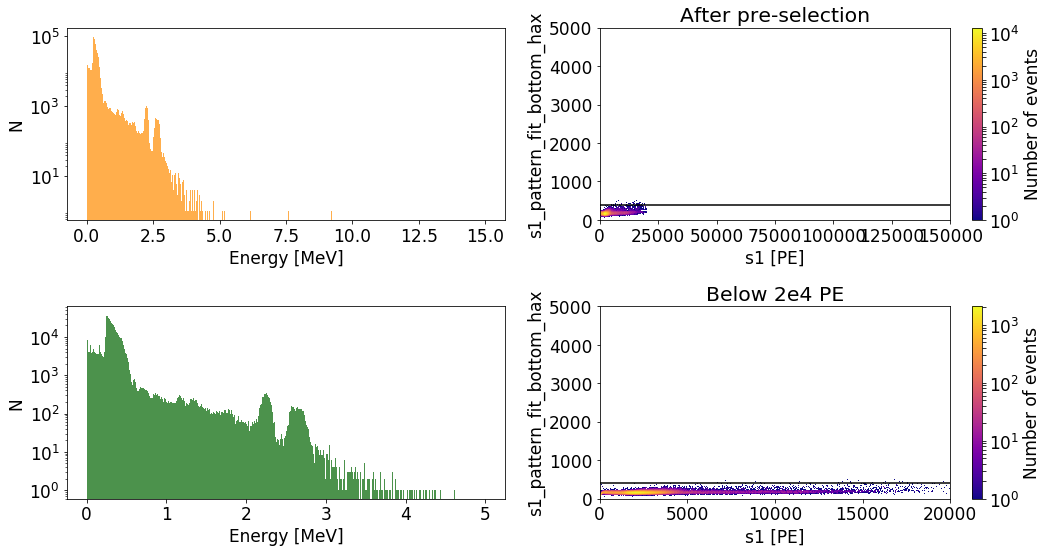

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           range=((0,1.5e5), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')
plt.hlines(y=400, xmax=1.5e5, xmin=0, colors='k', linestyles='solid')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')
plt.hlines(y=400, xmax=2e4, xmin=0, colors='k', linestyles='solid')


plt.tight_layout()
plt.show()

### Cut definition 

In [8]:
def S1PatternLikelihoodProfile_old(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

def S1PatternLikelihoodProfile_old_2(x, a, b, c, d):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5)

In [9]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def poly1(x, p0, p1):
    return p0 + p1 * x

def poly2(x, p0, p1, p2):
    return p0 + p1 * x + p2 * x**2

def poly3(x, p0, p1, p2, p3):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3

def poly1_3(x, p0, p1, p3):
    return p0 + p1 * x + p3 * x**3

def S1PatternLikelihoodProfile_new(x, p0, p1, p2, p3, p4, p5):
    return poly5(x, p0, p1, p2, p3, p4, p5)

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

In [10]:
hist_1, xbins_1, ybins_1 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (30, 200), 
                                   range=((0,600), (0,1000))
                                   )
ybins_center_1 = [0.5*(ybins_1[i]+ybins_1[i+1]) for i in range(len(ybins_1)-1)]
xbins_center_1 = [0.5*(xbins_1[i]+xbins_1[i+1]) for i in range(len(xbins_1)-1)]

perc_1 = np.empty(len(xbins_center_1))
for i in tqdm(range(len(hist_1))):
    perc_1[i] = percentile(index = i, hist=hist_1, ybins=ybins_1, xbins=xbins_1, q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_1, perc_valid_1 = dropNaNforFit(xbins_center_1, perc_1)
xbins_center_valid_1, perc_valid_1 = dropNegforFit(xbins_center_valid_1, perc_valid_1)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

100%|██████████| 30/30 [00:02<00:00, 10.02it/s]


In [11]:
hist_2, xbins_2, ybins_2 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (300, 200), 
                                   range=((600,1.5e4), (0,1000))
                                   )
ybins_center_2 = [0.5*(ybins_2[i]+ybins_2[i+1]) for i in range(len(ybins_2)-1)]
xbins_center_2 = [0.5*(xbins_2[i]+xbins_2[i+1]) for i in range(len(xbins_2)-1)]

perc_2 = np.empty(len(xbins_center_2))
for i in tqdm(range(len(hist_2))):
    perc_2[i] = percentile(index = i, hist=hist_2, ybins=ybins_2, xbins=xbins_2, q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_2, perc_valid_2 = dropNaNforFit(xbins_center_2, perc_2)
xbins_center_valid_2, perc_valid_2 = dropNegforFit(xbins_center_valid_2, perc_valid_2)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

100%|██████████| 300/300 [00:29<00:00, 10.17it/s]


In [12]:
hist_3, xbins_3, ybins_3 = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (10, 200), 
                                   range=((1.5e4,2e4), (0,1000))
                                   )
ybins_center_3 = [0.5*(ybins_3[i]+ybins_3[i+1]) for i in range(len(ybins_3)-1)]
xbins_center_3 = [0.5*(xbins_3[i]+xbins_3[i+1]) for i in range(len(xbins_3)-1)]

perc_3 = np.empty(len(xbins_center_3))
for i in tqdm(range(len(hist_3))):
    perc_3[i] = percentile(index = i, hist=hist_3, ybins=ybins_3, xbins=xbins_3, q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_3, perc_valid_3 = dropNaNforFit(xbins_center_3, perc_3)
xbins_center_valid_3, perc_valid_3 = dropNegforFit(xbins_center_valid_3, perc_valid_3)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

100%|██████████| 10/10 [00:00<00:00, 11.93it/s]


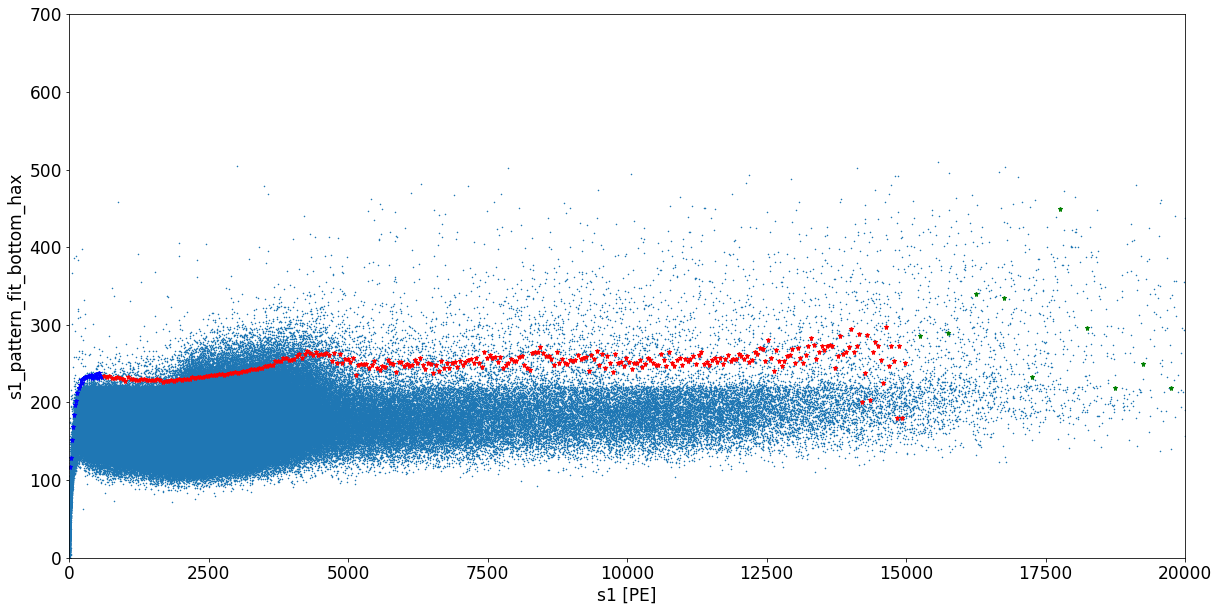

In [13]:
plt.plot(data['s1'], data['s1_pattern_fit_bottom_hax'], '*', ms=1)
plt.plot(xbins_center_valid_1, perc_valid_1, 'b*', lw=2, ms=5)
plt.plot(xbins_center_valid_2, perc_valid_2, 'r*', lw=2, ms=5)
plt.plot(xbins_center_valid_3, perc_valid_3, 'g*', lw=2, ms=5)

plt.xlim(0,2e4)
plt.ylim(0,700)

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

In [14]:
xbins_center_valid = np.concatenate((xbins_center_valid_1, xbins_center_valid_2, xbins_center_valid_3))
perc_valid = np.concatenate((perc_valid_1, perc_valid_2, perc_valid_3))

In [15]:
 xbins_center_valid[30]

624.0

## Fit of the cut

In [16]:
init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02]#, 6.10027892e-04]

popt_1, pcov_1 = curve_fit(S1PatternLikelihoodProfile_old_2, xbins_center_valid[:30], perc_valid[:30], p0=init_1)
print('popt_1: ', popt_1 ,'\n\npcov_1: ', pcov_1)

init_2 = [1.94732562e+02, 2.06418467e-02, -2.51207789e-06, 9.83912470e-11]

popt_2, pcov_2 = curve_fit(poly3, xbins_center_valid[30:], perc_valid[30:], p0=init_2)
print('\npopt_2: ',popt_2, '\n\npcov_2: ', pcov_2)

popt_1:  [  5.45872853e+01   1.76215496e+01  -4.04532941e-01  -9.91982373e-04] 

pcov_1:  [[  8.94527673e+01  -2.20155583e+01   1.57703317e+00  -3.43957464e-02]
 [ -2.20155583e+01   5.93109760e+00  -4.46770153e-01   1.00618728e-02]
 [  1.57703317e+00  -4.46770153e-01   3.47916695e-02  -8.02171404e-04]
 [ -3.43957464e-02   1.00618728e-02  -8.02171404e-04   1.88253730e-05]]

popt_2:  [  2.22738437e+02   8.15653010e-03  -7.03429785e-07   2.26826861e-11] 

pcov_2:  [[  2.23945005e+01  -9.02427912e-03   9.79393445e-07  -3.11101959e-11]
 [ -9.02427912e-03   4.39311447e-06  -5.20820411e-10   1.74668692e-14]
 [  9.79393445e-07  -5.20820411e-10   6.55101676e-14  -2.29629468e-18]
 [ -3.11101959e-11   1.74668692e-14  -2.29629468e-18   8.35900039e-23]]


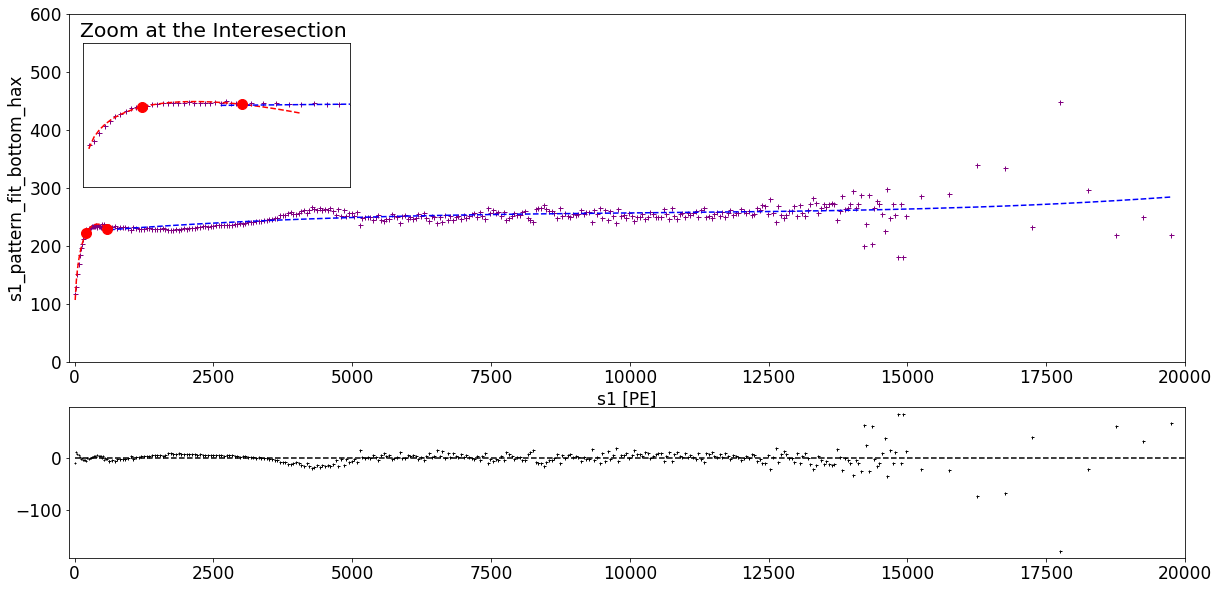

In [17]:
idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile_old_2(xbins_center_valid, *popt_1) - \
                                  poly3(xbins_center_valid, *popt_2)))).flatten()

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])

plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1), 'r--')
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-100, 2e4)
plt.ylim(0,600)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.axes([0.135, 0.64, .185, .2], facecolor='w')
plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid[:35], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:35], *popt_1), 'r--')
plt.plot(xbins_center_valid[25:], poly3(xbins_center_valid[25:], *popt_2), 'b--')
plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile_old_2(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)
plt.xlim(-10, 10e2)
plt.ylim(0,400)
plt.xticks([])
plt.yticks([])
plt.title('Zoom at the Interesection ')
#plt.xlabel('s1 [PE]')
#plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid[:31], *popt_1)-perc_valid[:31], 
         'k+', ms=2)
plt.plot(xbins_center_valid[30:], poly3(xbins_center_valid[30:], *popt_2)-perc_valid[30:], 
         'k+', ms=3)
plt.hlines(y=0, xmin=0, xmax=2e4, linestyles='dashed')
plt.xlim(-100, 2e4)

plt.show()

### Cut

In [18]:
data_cut = data.copy()
data_cut['CutS1PF'] = (((data_cut['s1_pattern_fit_bottom_hax'] < S1PatternLikelihoodProfile_old_2(data_cut['s1'], *popt_1))*(data_cut['s1']<xbins_center_valid[idx][0]))
                      +((data_cut['s1_pattern_fit_bottom_hax'] < poly3(data_cut['s1'], *popt_2))*(data_cut['s1']>=xbins_center_valid[idx][0])))
data_cut = hax.cuts.selection(data_cut, data_cut['CutS1PF'] == True)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 8623 rows removed (99.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


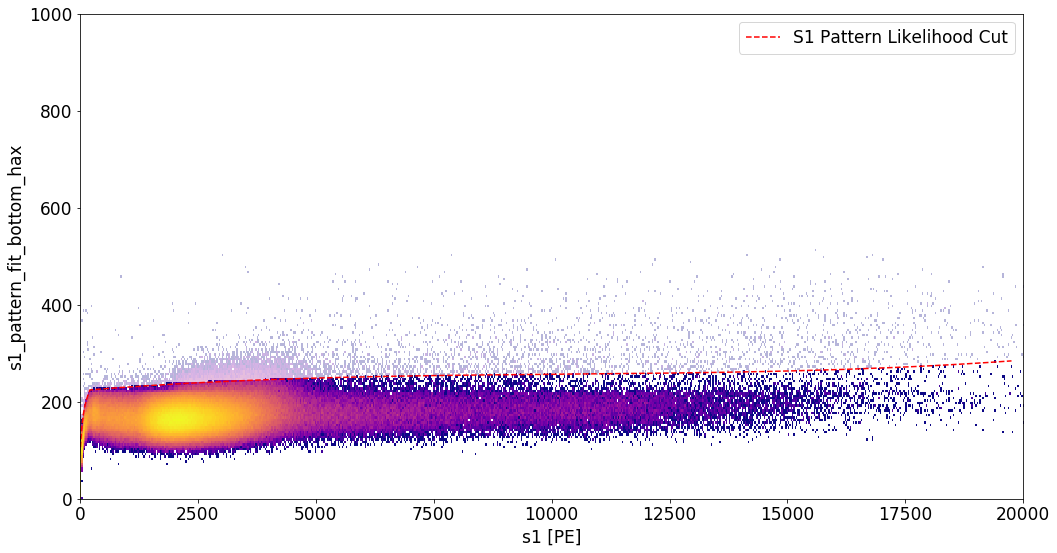

In [19]:
y_valid = []
for i in range(len(xbins_center_valid)):
    y_valid.append((S1PatternLikelihoodProfile_old_2(xbins_center_valid[i], *popt_1))*(xbins_center_valid[i]<xbins_center_valid[idx][0]) + \
                 (poly3(xbins_center_valid[i], *popt_2))*(xbins_center_valid[i]>=xbins_center_valid[idx][0]))

plt.figure(figsize=(15,8))
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_bottom_hax'], bins = (700, 200), 
           range=((0,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [20]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_centers_acceptance.append((xbins_cut[i+1] + xbins_cut[i])/2.)
    acceptance.append(hist_cut[i].sum()/hist[i].sum())
    sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))
    
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance_nan = acceptance[np.logical_not(np.isnan(acceptance))]
sigma_nan = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance_nan)
acceptance_median = np.median(acceptance_nan)

print(acceptance_mean, acceptance_median)

0.869629763774 0.940860215054


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
bin_centers_acceptance[380]

10871.428571428572

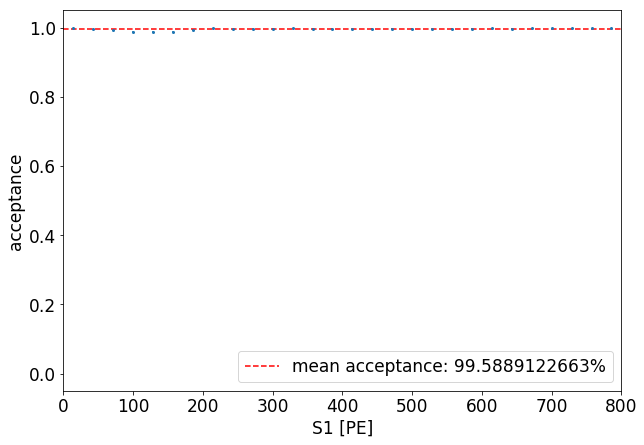

In [22]:
acceptance_mean = np.mean(acceptance_nan[:30])
acceptance_median = np.median(acceptance_nan[:30])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=8e2, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 800)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

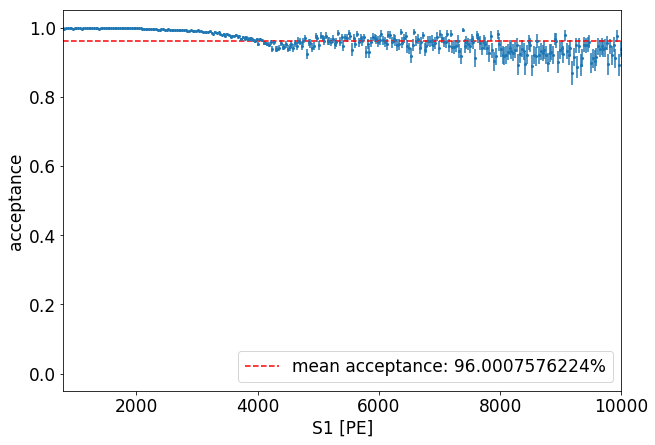

In [23]:
acceptance_mean = np.mean(acceptance_nan[30:380])
acceptance_median = np.median(acceptance_nan[40:380])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=8e2, xmax=1e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(8e2, 1e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

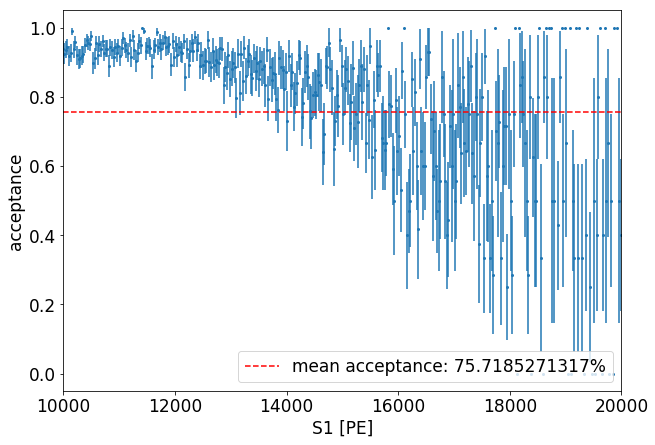

In [24]:
acceptance_mean = np.mean(acceptance_nan[380:])
acceptance_median = np.median(acceptance_nan[380:])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e4, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e4, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

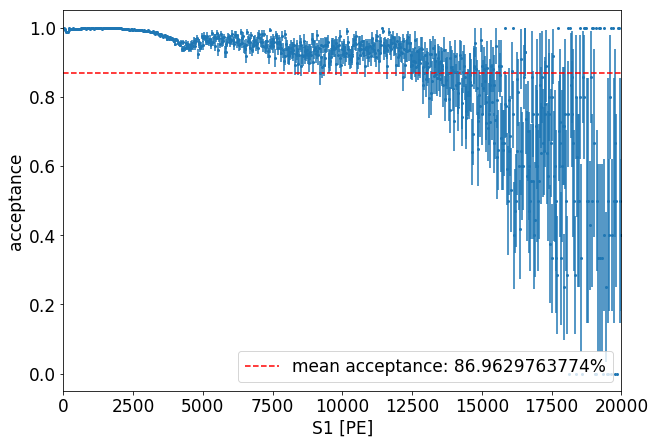

In [25]:
plt.figure(figsize=(10,7))

acceptance_mean = np.mean(acceptance_nan[:])
acceptance_median = np.median(acceptance_nan[:])

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

## Acceptance study on xyz

In [26]:
data_cut_2 = data_cut.copy()
data_cut_2['theta_3d_nn_tf'] = 2 * np.pi * np.arctan(data_cut_2['y_3d_nn_tf']/data_cut_2['x_3d_nn_tf'])
tmp = data_cut_2.copy()
z1 = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2 = tmp[(tmp['z_3d_nn_tf']>-60) & (tmp['z_3d_nn_tf']<=-30)]
z3 = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-60)]
tmp = data.copy()
z1_white = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2_white = tmp[(tmp['z_3d_nn_tf']>-60) & (tmp['z_3d_nn_tf']<=-30)]
z3_white = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-60)]
del tmp

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


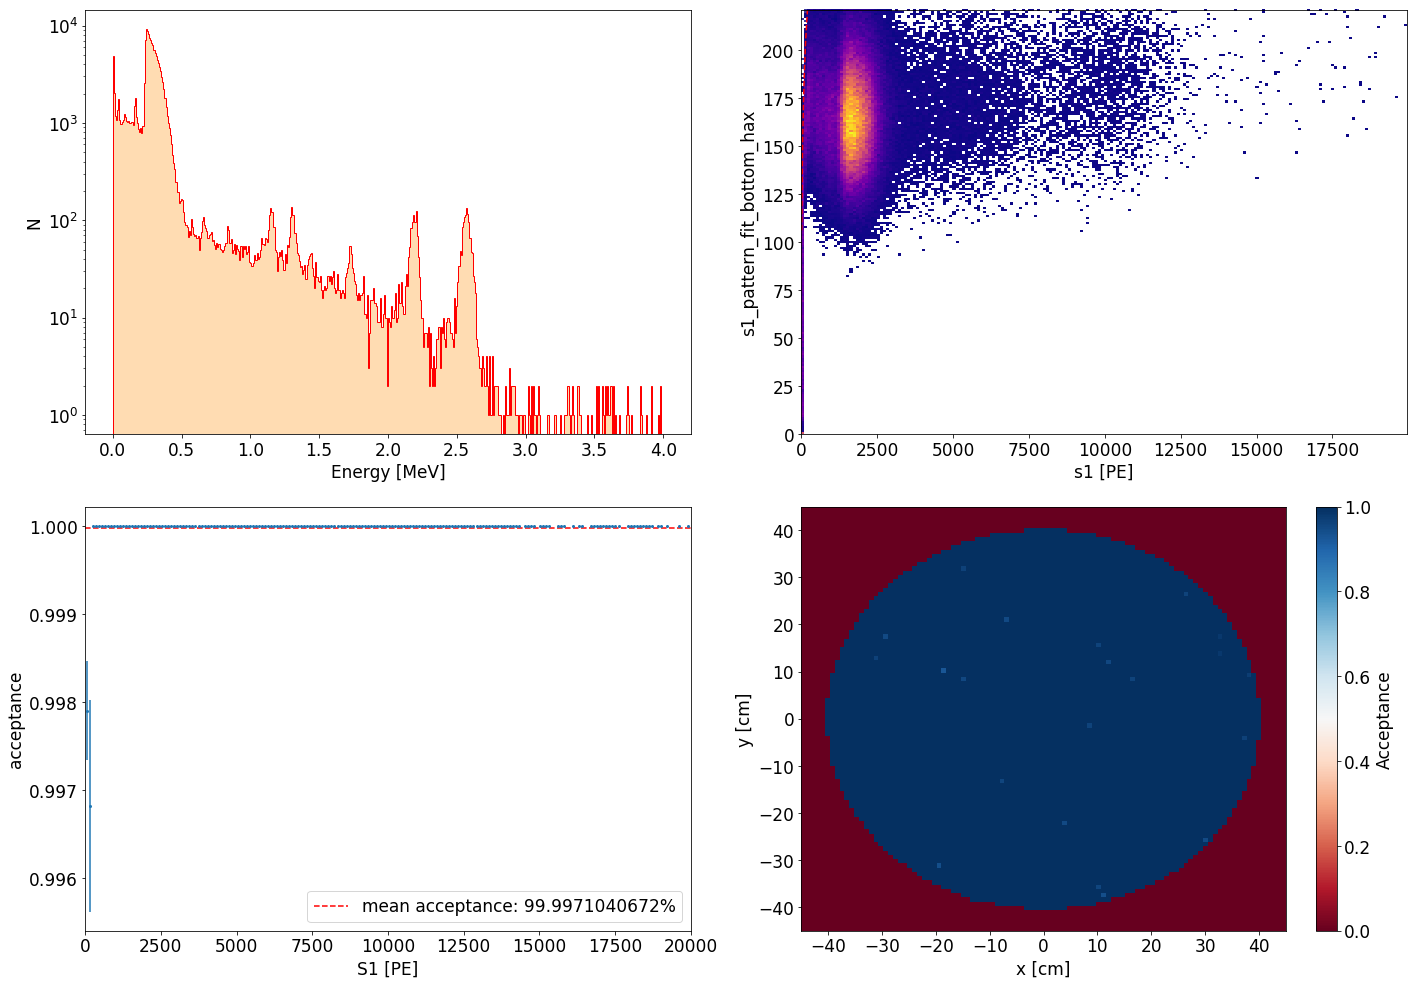

In [49]:
plt.figure(figsize=(20,14))

plt.subplot(221)
plt.hist(z1_white['CES']/10**6, bins = (500), 
         range=(0, 4), 
         histtype='bar', color='darkorange',
         alpha = 0.3)
plt.hist(z1['CES']/10**6, bins = (500), 
         range=(0, 4), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
hist_z1, xbins_z1, ybins_z1, _ = plt.hist2d(z1_white['s1'], z1_white['s1_pattern_fit_bottom_hax'], bins = (200, 200), 
                                            #range=((0,2e4), (0,1000)), 
                                            cmap=plt.cm.plasma, #norm=matplotlib.colors.LogNorm(), 
                                            cmin = 1,alpha = 0.8)
hist_z1_cut, xbins_z1_cut, ybins_z1_cut, _ = plt.hist2d(z1['s1'], z1['s1_pattern_fit_bottom_hax'], bins = (200, 200), 
                                            #range=((0,2e4), (0,1000)), 
                                            cmap=plt.cm.plasma, #norm=matplotlib.colors.LogNorm(), 
                                            cmin = 1,alpha = 1)
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')

hist_z1[np.isnan(hist_z1)] = 0
hist_z1_cut[np.isnan(hist_z1_cut)] = 0

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(223)

bin_centers_acceptance_z1 = []
acceptance_z1 = []
sigma_z1 = []
for i in range(len(xbins_z1_cut)-1):
    bin_centers_acceptance_z1.append((xbins_z1_cut[i+1] + xbins_z1_cut[i])/2.)
    acceptance_z1.append(hist_z1_cut[i].sum()/hist_z1[i].sum())
    sigma_z1.append(np.sqrt(acceptance_z1[i]*(1-acceptance_z1[i])/hist_z1[i].sum()))
    
bin_centers_acceptance_z1 = np.array(bin_centers_acceptance_z1)
acceptance_z1 = np.array(acceptance_z1)
sigma_z1 = np.array(sigma_z1)
acceptance_nan_z1 = acceptance_z1[np.logical_not(np.isnan(acceptance_z1))]
sigma_nan_z1 = sigma_z1[np.logical_not(np.isnan(sigma_z1))]
acceptance_mean_z1 = np.mean(acceptance_nan_z1)
acceptance_median_z1 = np.median(acceptance_nan_z1)

plt.errorbar(bin_centers_acceptance_z1, acceptance_z1, yerr=sigma_z1, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean_z1, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean_z1) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

plt.subplot(224)
hist_data_1, x_data_1, y_data_1 = np.histogram2d(z1_white['x_3d_nn_tf'], z1_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_1, x_cut_1, y_cut_1 = np.histogram2d(z1['x_3d_nn_tf'], z1['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_1 = hist_cut_1/hist_data_1
c_1 = plt.pcolor(x_data_1, y_data_1, Acceptance_xy_1, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


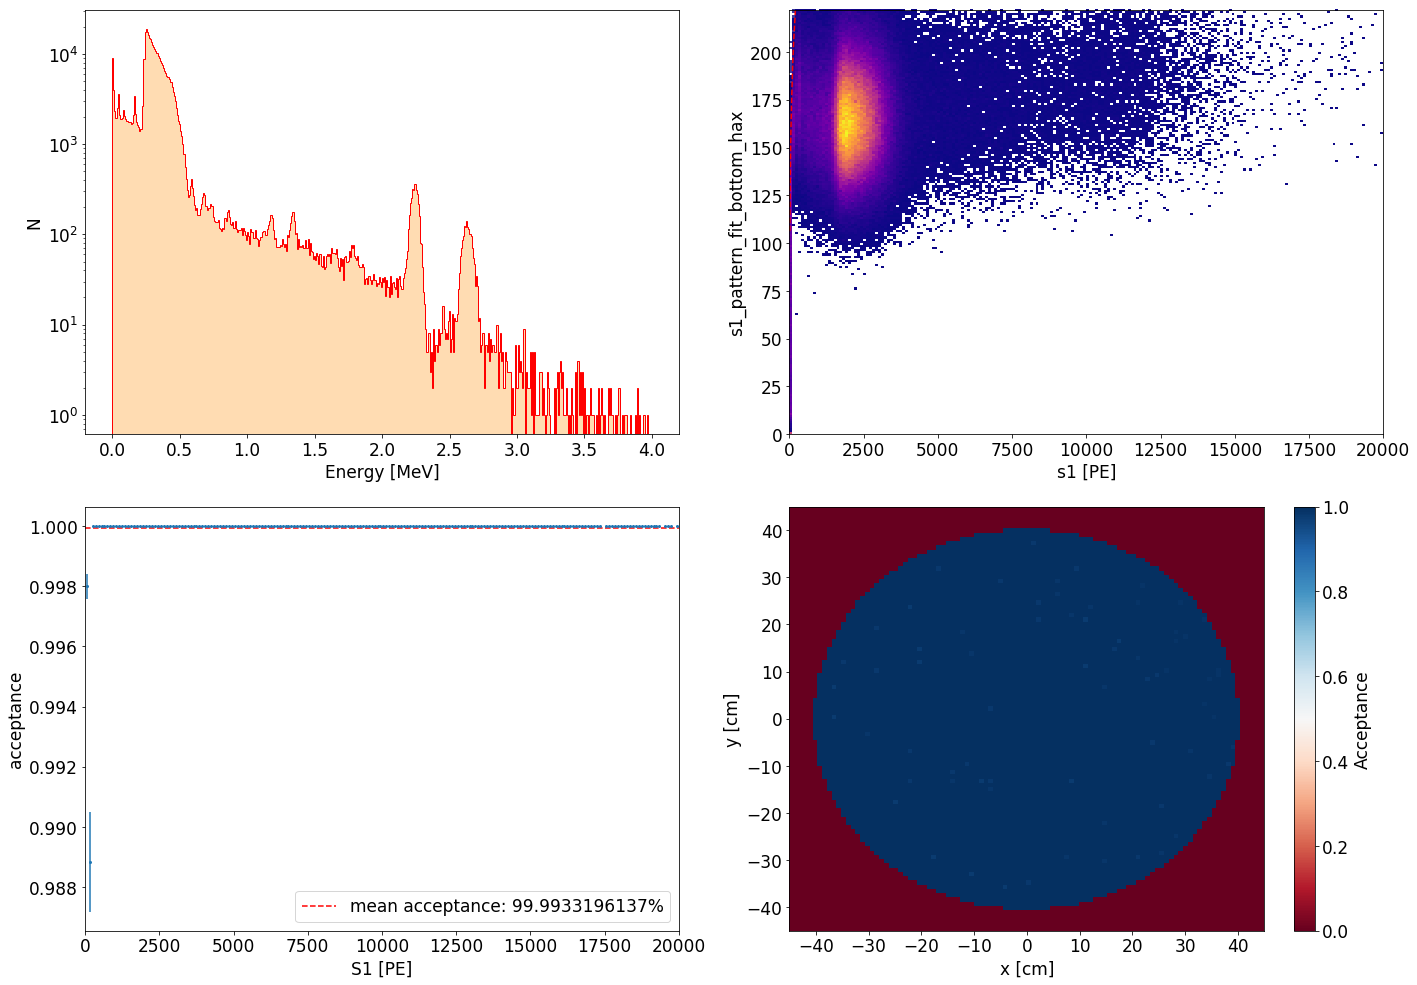

In [28]:
plt.figure(figsize=(20,14))

plt.subplot(221)
plt.hist(z2_white['CES']/10**6, bins = (500), 
         range=(0, 4), 
         histtype='bar', color='darkorange',
         alpha = 0.3)
plt.hist(z2['CES']/10**6, bins = (500), 
         range=(0, 4), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
hist_z2, xbins_z2, ybins_z2, _ = plt.hist2d(z2_white['s1'], z2_white['s1_pattern_fit_bottom_hax'], bins = (200, 200), 
                                            #range=((0,2e4), (0,1000)), 
                                            cmap=plt.cm.plasma, #norm=matplotlib.colors.LogNorm(), 
                                            cmin = 1,alpha = 0.8)
hist_z2_cut, xbins_z2_cut, ybins_z2_cut, _ = plt.hist2d(z2['s1'], z2['s1_pattern_fit_bottom_hax'], bins = (200, 200), 
                                            #range=((0,2e4), (0,1000)), 
                                            cmap=plt.cm.plasma, #norm=matplotlib.colors.LogNorm(), 
                                            cmin = 1,alpha = 1)
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')

hist_z2[np.isnan(hist_z2)] = 0
hist_z2_cut[np.isnan(hist_z2_cut)] = 0

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(223)

bin_centers_acceptance_z2 = []
acceptance_z2 = []
sigma_z2 = []
for i in range(len(xbins_z2_cut)-1):
    bin_centers_acceptance_z2.append((xbins_z2_cut[i+1] + xbins_z2_cut[i])/2.)
    acceptance_z2.append(hist_z2_cut[i].sum()/hist_z2[i].sum())
    sigma_z2.append(np.sqrt(acceptance_z2[i]*(1-acceptance_z2[i])/hist_z2[i].sum()))
    
bin_centers_acceptance_z2 = np.array(bin_centers_acceptance_z2)
acceptance_z2 = np.array(acceptance_z2)
sigma_z2 = np.array(sigma_z2)
acceptance_nan_z2 = acceptance_z2[np.logical_not(np.isnan(acceptance_z2))]
sigma_nan_z2 = sigma_z2[np.logical_not(np.isnan(sigma_z2))]
acceptance_mean_z2 = np.mean(acceptance_nan_z2)
acceptance_median_z2 = np.median(acceptance_nan_z2)

plt.errorbar(bin_centers_acceptance_z2, acceptance_z2, yerr=sigma_z2, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean_z2, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean_z2) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

plt.subplot(224)
hist_data_2, x_data_2, y_data_2 = np.histogram2d(z2_white['x_3d_nn_tf'], z2_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_2, x_cut_2, y_cut_2 = np.histogram2d(z2['x_3d_nn_tf'], z2['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_2 = hist_cut_2/hist_data_2
c_2 = plt.pcolor(x_data_2, y_data_2, Acceptance_xy_2, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_2, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


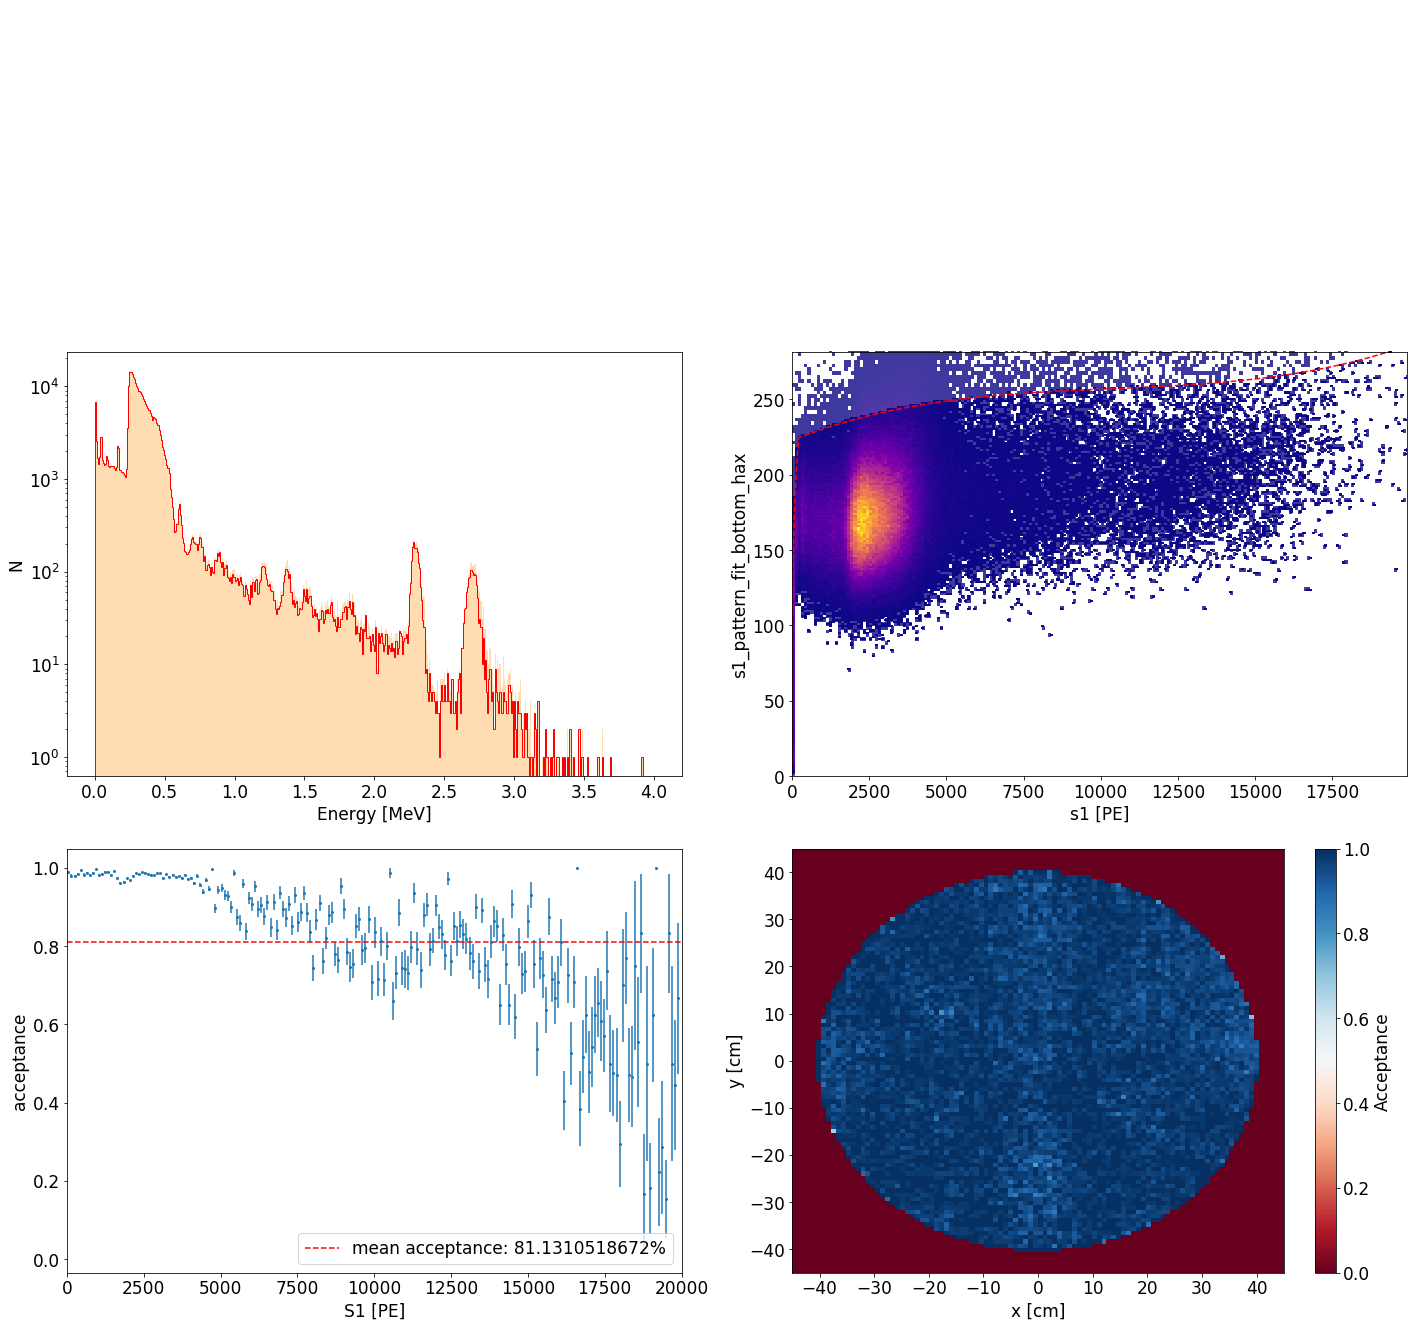

In [29]:
plt.figure(figsize=(20,14))

plt.subplot(221)
plt.hist(z3_white['CES']/10**6, bins = (500), 
         range=(0, 4), 
         histtype='bar', color='darkorange',
         alpha = 0.3)
plt.hist(z3['CES']/10**6, bins = (500), 
         range=(0, 4), 
         histtype='step', color='red',
         alpha = 1)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
hist_z3, xbins_z3, ybins_z3, _ = plt.hist2d(z3_white['s1'], z3_white['s1_pattern_fit_bottom_hax'], bins = (200, 200), 
                                            #range=((0,2e4), (0,1000)), 
                                            cmap=plt.cm.plasma, #norm=matplotlib.colors.LogNorm(), 
                                            cmin = 1,alpha = 0.8)
hist_z3_cut, xbins_z3_cut, ybins_z3_cut, _ = plt.hist2d(z3['s1'], z3['s1_pattern_fit_bottom_hax'], bins = (200, 200), 
                                            #range=((0,2e4), (0,1000)), 
                                            cmap=plt.cm.plasma, #norm=matplotlib.colors.LogNorm(), 
                                            cmin = 1,alpha = 1)
plt.plot(xbins_center_valid, y_valid, 'r--', label = 'S1 Pattern Likelihood Cut')

hist_z3[np.isnan(hist_z3)] = 0
hist_z3_cut[np.isnan(hist_z3_cut)] = 0

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(223)

bin_centers_acceptance_z3 = []
acceptance_z3 = []
sigma_z3 = []
for i in range(len(xbins_z3_cut)-1):
    bin_centers_acceptance_z3.append((xbins_z3_cut[i+1] + xbins_z3_cut[i])/2.)
    acceptance_z3.append(hist_z3_cut[i].sum()/hist_z3[i].sum())
    sigma_z3.append(np.sqrt(acceptance_z3[i]*(1-acceptance_z3[i])/hist_z3[i].sum()))
    
bin_centers_acceptance_z3 = np.array(bin_centers_acceptance_z3)
acceptance_z3 = np.array(acceptance_z3)
sigma_z3 = np.array(sigma_z3)
acceptance_nan_z3 = acceptance_z3[np.logical_not(np.isnan(acceptance_z3))]
sigma_nan_z3 = sigma_z3[np.logical_not(np.isnan(sigma_z3))]
acceptance_mean_z3 = np.mean(acceptance_nan_z3)
acceptance_median_z3 = np.median(acceptance_nan_z3)

plt.errorbar(bin_centers_acceptance_z3, acceptance_z3, yerr=sigma_z3, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean_z3, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean_z3) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

plt.subplot(224)
hist_data_3, x_data_3, y_data_3 = np.histogram2d(z3_white['x_3d_nn_tf'], z3_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_3, x_cut_3, y_cut_3 = np.histogram2d(z3['x_3d_nn_tf'], z3['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_3 = hist_cut_3/hist_data_3
c_3 = plt.pcolor(x_data_3, y_data_3, Acceptance_xy_3, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_3, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


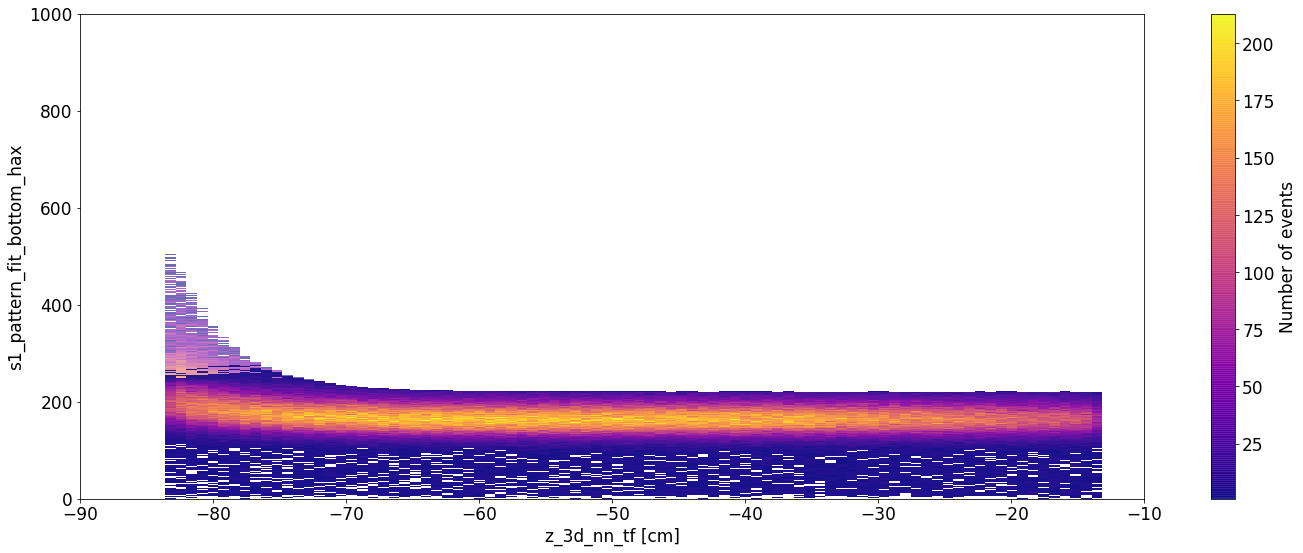

In [30]:
fig = plt.figure(figsize=(20,8))

hist_z, xbins_z, ybins_z, _ = plt.hist2d(data['z_3d_nn_tf'], 
                                         data['s1_pattern_fit_bottom_hax'],
                                         bins=(100,1000), 
                                         range=((-90, -10), (0.0,1000)), 
                                         cmap=plt.cm.plasma, 
                                         norm=matplotlib.colors.LogNorm(),
                                         cmin = 1,alpha = 0.60)
#plt.colorbar(label='Number of events')

hist_z_cut, xbins_z_cut, ybins_z_cut, _ = plt.hist2d(data_cut_2['z_3d_nn_tf'], 
                                                     data_cut_2['s1_pattern_fit_bottom_hax'], 
                                                     bins=(100,1000), 
                                                     range=((-90, -10), (0.0,1000)), 
                                                     cmap=plt.cm.plasma, 
                                                     #norm=matplotlib.colors.LogNorm(),
                                                     cmin = 1,alpha = 0.9)
plt.colorbar(label='Number of events')

plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()

hist_z[np.isnan(hist_z)] = 0
hist_z_cut[np.isnan(hist_z_cut)] = 0

Unnamed selection: 12 rows removed (88.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


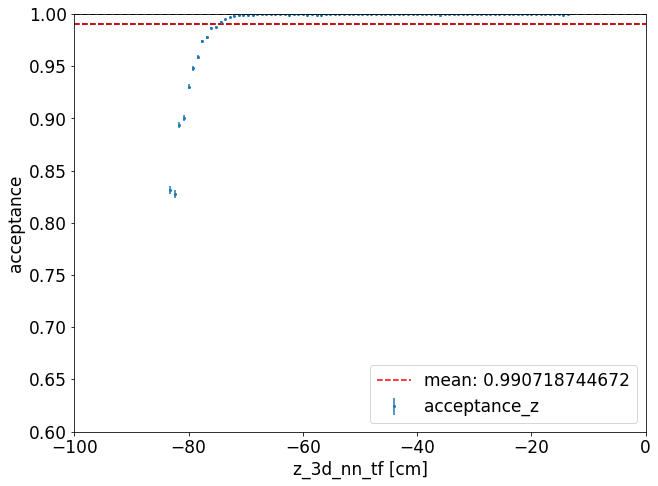

In [31]:
bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_z_cut[i].sum()/hist_z[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_z[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)

tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

del tmp


plt.figure(figsize=(10.24, 7.68))

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.legend(loc='lower right')
plt.xlim(-100, 0)
plt.ylim(0.60, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')



/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


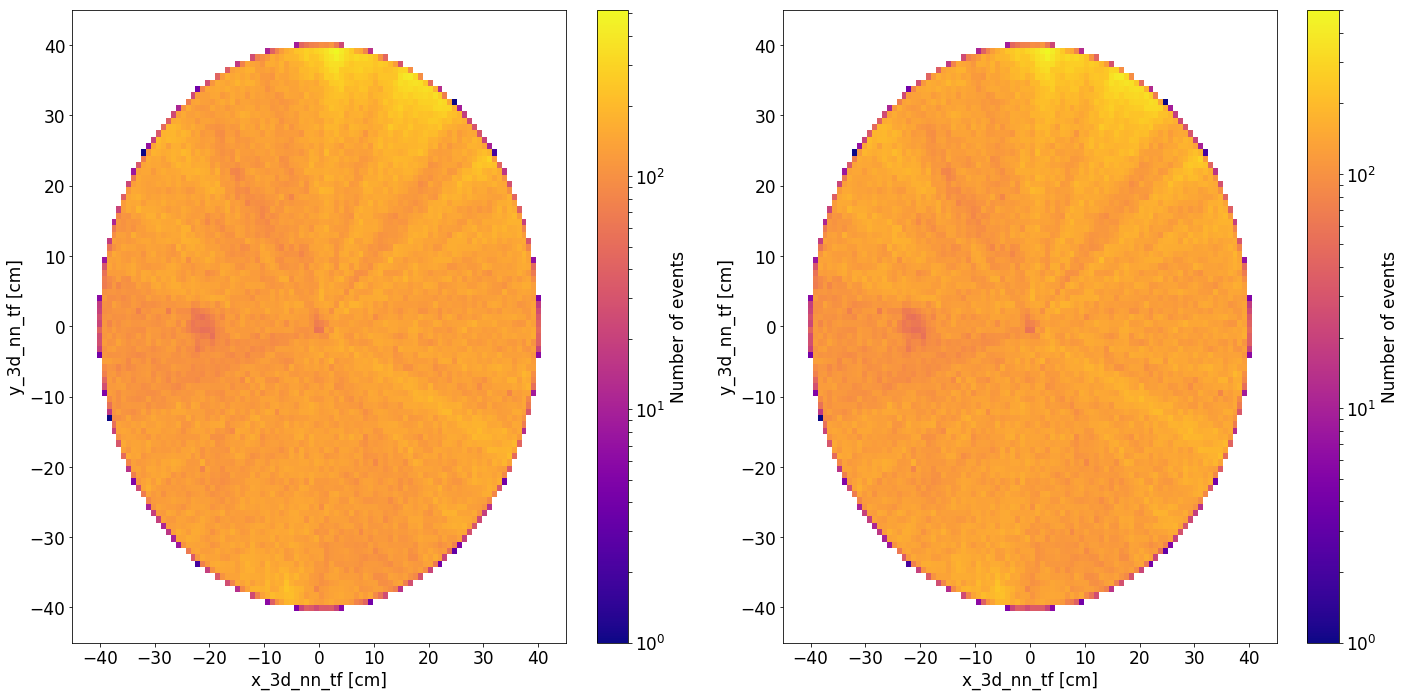

In [32]:
#plt.figure(figsize=(12,6))
plt.subplot(121)
hist_data, x_data, y_data, image_data = plt.hist2d(data['x_3d_nn_tf'], 
                                                   data['y_3d_nn_tf'], 
                                                   bins=(100,100), 
                                                   range=((-45, +45), (-45, +45)), 
                                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                                   cmin = 1,alpha = 1) 
plt.xlabel('x_3d_nn_tf [cm]')
plt.ylabel('y_3d_nn_tf [cm]')
plt.colorbar(label='Number of events')

plt.subplot(122)
hist_cut, x_cut, y_cut, image_cut = plt.hist2d(data_cut_2['x_3d_nn_tf'], 
                                               data_cut_2['y_3d_nn_tf'], 
                                               bins=(100,100), 
                                               range=((-45, +45), (-45, +45)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                               cmin = 1,alpha = 1) 
plt.xlabel('x_3d_nn_tf [cm]')
plt.ylabel('y_3d_nn_tf [cm]')
plt.colorbar(label='Number of events')
plt.tight_layout()

Acceptance_xy = hist_cut/hist_data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


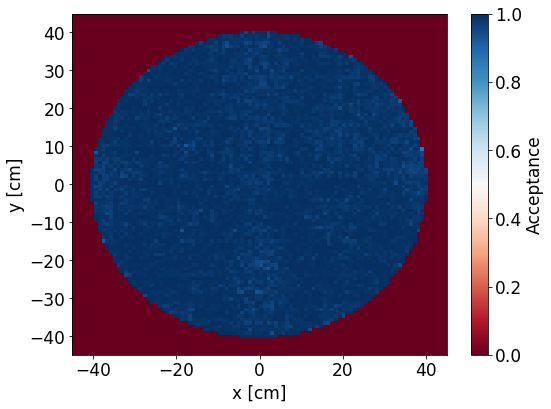

In [33]:
plt.figure(figsize=(8,6))
c = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


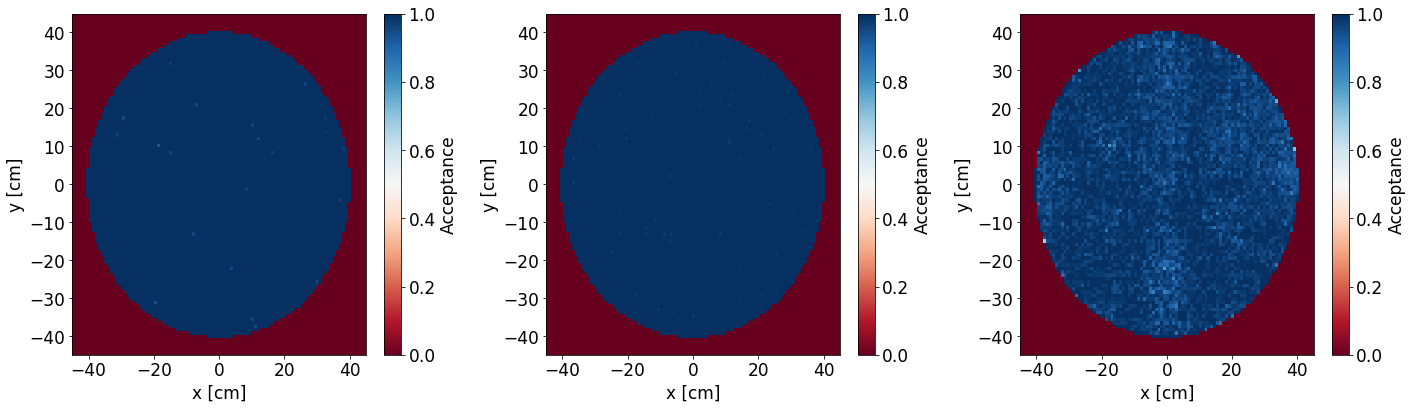

In [34]:
plt.figure(figsize=(20,6))

plt.subplot(131)
hist_data_1, x_data_1, y_data_1 = np.histogram2d(z1_white['x_3d_nn_tf'], z1_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_1, x_cut_1, y_cut_1 = np.histogram2d(z1['x_3d_nn_tf'], z1['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_1 = hist_cut_1/hist_data_1
c_1 = plt.pcolor(x_data_1, y_data_1, Acceptance_xy_1, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.subplot(132)
hist_data_2, x_data_2, y_data_2 = np.histogram2d(z2_white['x_3d_nn_tf'], z2_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_2, x_cut_2, y_cut_2 = np.histogram2d(z2['x_3d_nn_tf'], z2['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_2 = hist_cut_2/hist_data_2
c_2 = plt.pcolor(x_data_2, y_data_2, Acceptance_xy_2, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_2, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.subplot(133)
hist_data_3, x_data_3, y_data_3 = np.histogram2d(z3_white['x_3d_nn_tf'], z3_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_3, x_cut_3, y_cut_3 = np.histogram2d(z3['x_3d_nn_tf'], z3['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_3 = hist_cut_3/hist_data_3
c_3 = plt.pcolor(x_data_3, y_data_3, Acceptance_xy_3, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_3, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.tight_layout()

## What is it going on at low z?

# TOP

In [35]:
data_top_white = [z1_white, z2_white]
data_top_white = pd.concat(data_top_white, ignore_index=True)

In [36]:
hist_top_white_1, xbins_top_white_1, ybins_top_white_1 = np.histogram2d(data_top_white['s1'], data_top_white['s1_pattern_fit_bottom_hax'], 
                                                                        bins = (30, 200), 
                                                                        range=((0,600), (0,1000))
                                                                        )
ybins_center_top_white_1 = [0.5*(ybins_top_white_1[i]+ybins_top_white_1[i+1]) for i in range(len(ybins_top_white_1)-1)]
xbins_center_top_white_1 = [0.5*(xbins_top_white_1[i]+xbins_top_white_1[i+1]) for i in range(len(xbins_top_white_1)-1)]

perc_top_white_1 = np.empty(len(xbins_center_top_white_1))
for i in tqdm(range(len(hist_top_white_1))):
    perc_top_white_1[i] = percentile(index = i, hist=hist_top_white_1, ybins=ybins_top_white_1, xbins=xbins_top_white_1,
                                     q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_top_white_1, perc_valid_top_white_1 = dropNaNforFit(xbins_center_top_white_1, perc_top_white_1)
xbins_center_valid_top_white_1, perc_valid_top_white_1 = dropNegforFit(xbins_center_valid_top_white_1, perc_valid_top_white_1)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

hist_top_white_2, xbins_top_white_2, ybins_top_white_2 = np.histogram2d(data_top_white['s1'], data_top_white['s1_pattern_fit_bottom_hax'], 
                                                                        bins = (300, 200), 
                                                                        range=((600,1.5e4), (0,1000))
                                                                        )
ybins_center_top_white_2 = [0.5*(ybins_top_white_2[i]+ybins_top_white_2[i+1]) for i in range(len(ybins_top_white_2)-1)]
xbins_center_top_white_2 = [0.5*(xbins_top_white_2[i]+xbins_top_white_2[i+1]) for i in range(len(xbins_top_white_2)-1)]

perc_top_white_2 = np.empty(len(xbins_center_top_white_2))
for i in tqdm(range(len(hist_top_white_2))):
    perc_top_white_2[i] = percentile(index = i, hist=hist_top_white_2, ybins=ybins_top_white_2, xbins=xbins_top_white_2,
                                     q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_top_white_2, perc_valid_top_white_2 = dropNaNforFit(xbins_center_top_white_2, perc_top_white_2)
xbins_center_valid_top_white_2, perc_valid_top_white_2 = dropNegforFit(xbins_center_valid_top_white_2, perc_valid_top_white_2)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

hist_top_white_3, xbins_top_white_3, ybins_top_white_3 = np.histogram2d(data_top_white['s1'], data_top_white['s1_pattern_fit_bottom_hax'],
                                                                        bins = (10, 200), 
                                                                        range=((1.5e4,2e4), (0,1000))
                                                                        )
ybins_center_top_white_3 = [0.5*(ybins_top_white_3[i]+ybins_top_white_3[i+1]) for i in range(len(ybins_top_white_3)-1)]
xbins_center_top_white_3 = [0.5*(xbins_top_white_3[i]+xbins_top_white_3[i+1]) for i in range(len(xbins_top_white_3)-1)]

perc_top_white_3 = np.empty(len(xbins_center_top_white_3))
for i in tqdm(range(len(hist_top_white_3))):
    perc_top_white_3[i] = percentile(index = i, hist=hist_top_white_3, ybins=ybins_top_white_3, xbins=xbins_top_white_3, q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_top_white_3, perc_valid_top_white_3 = dropNaNforFit(xbins_center_top_white_3, perc_top_white_3)
xbins_center_valid_top_white_3, perc_valid_top_white_3 = dropNegforFit(xbins_center_valid_top_white_3, perc_valid_top_white_3)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


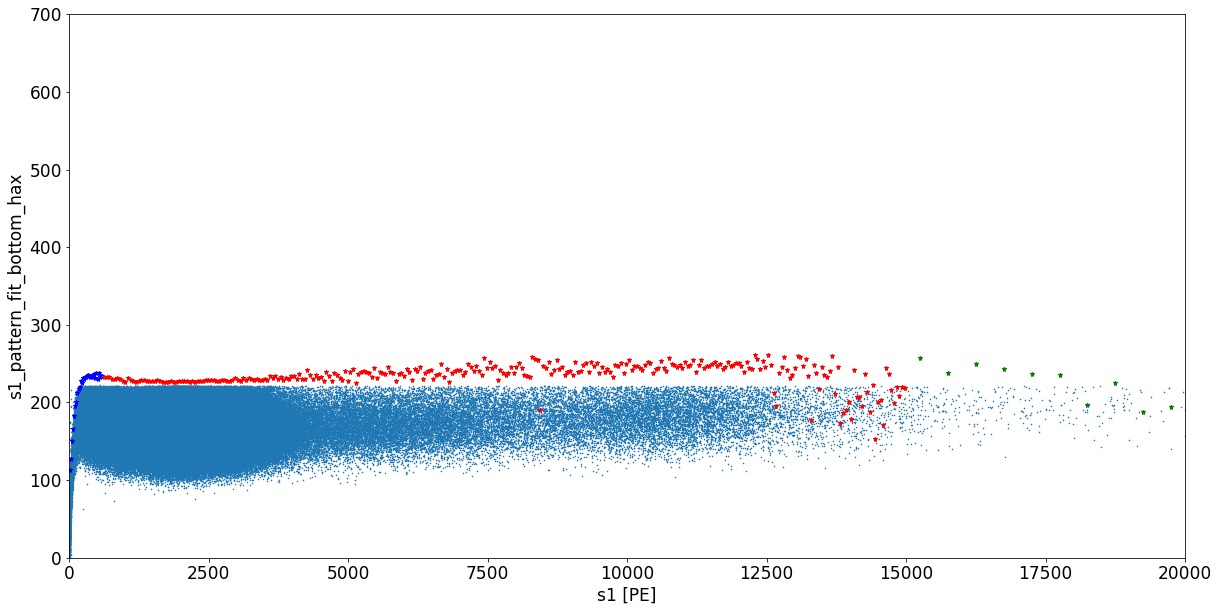

In [37]:
plt.plot(data_top_white['s1'], data_top_white['s1_pattern_fit_bottom_hax'], '*', ms=1)
plt.plot(xbins_center_valid_top_white_1, perc_valid_top_white_1, 'b*', lw=2, ms=5)
plt.plot(xbins_center_valid_top_white_2, perc_valid_top_white_2, 'r*', lw=2, ms=5)
plt.plot(xbins_center_valid_top_white_3, perc_valid_top_white_3, 'g*', lw=2, ms=5)

plt.xlim(0,2e4)
plt.ylim(0,700)

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

[  5.45872853e+01   1.76215496e+01  -4.04532941e-01  -9.91982373e-04] 

 [[  8.94527673e+01  -2.20155583e+01   1.57703317e+00  -3.43957464e-02]
 [ -2.20155583e+01   5.93109760e+00  -4.46770153e-01   1.00618728e-02]
 [  1.57703317e+00  -4.46770153e-01   3.47916695e-02  -8.02171404e-04]
 [ -3.43957464e-02   1.00618728e-02  -8.02171404e-04   1.88253730e-05]]
[  2.13110917e+02   1.50571254e-02  -1.87467679e-06   7.76511463e-11] 

 [[  6.08276331e+00  -3.50338821e-03   5.46968025e-07  -2.50725617e-11]
 [ -3.50338821e-03   2.35262080e-06  -3.94745957e-10   1.88692586e-14]
 [  5.46968025e-07  -3.94745957e-10   6.94178443e-14  -3.42508766e-18]
 [ -2.50725617e-11   1.88692586e-14  -3.42508766e-18   1.72984226e-22]]


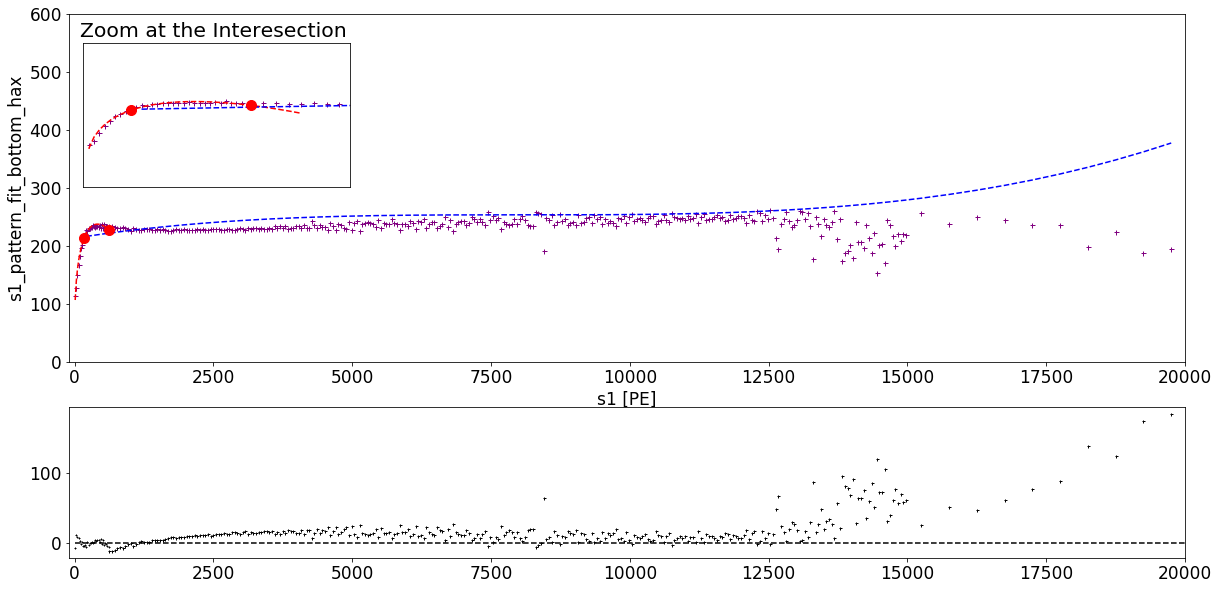

In [38]:
xbins_center_valid_top_white = np.concatenate((xbins_center_valid_top_white_1, xbins_center_valid_top_white_2, xbins_center_valid_top_white_3))
perc_valid_top_white = np.concatenate((perc_valid_top_white_1, perc_valid_top_white_2, perc_valid_top_white_3))

init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02]#, 6.10027892e-04]

popt_1_top_white, pcov_1_top_white = curve_fit(S1PatternLikelihoodProfile_old_2, xbins_center_valid_top_white[:30], perc_valid[:30], p0=init_1)
print(popt_1_top_white ,'\n\n', pcov_1_top_white)

init_2 = [1.94732562e+02, 2.06418467e-02, -2.51207789e-06, 9.83912470e-11]
#init_2 = [1.94732562e+02, 2.06418467e-02,  9.83912470e-11]

popt_2_top_white, pcov_2_top_white = curve_fit(poly3, xbins_center_valid_top_white[30:280], perc_valid[30:280], p0=init_2)
print(popt_2_top_white, '\n\n', pcov_2_top_white)

idx_top_white = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white, *popt_1_top_white) - \
                                  poly3(xbins_center_valid_top_white, *popt_2_top_white)))).flatten()

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])

plt.plot(xbins_center_valid_top_white[:], perc_valid_top_white[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid_top_white[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white[:31], *popt_1_top_white), 'r--')
plt.plot(xbins_center_valid_top_white[10:], poly3(xbins_center_valid_top_white[10:], *popt_2_top_white), 'b--')
plt.plot(xbins_center_valid_top_white[idx_top_white], S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white[idx_top_white], *popt_1_top_white), 'ro' , ms=10)
plt.xlim(-100, 2e4)
plt.ylim(0,600)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.axes([0.135, 0.64, .185, .2], facecolor='w')
plt.plot(xbins_center_valid_top_white[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid_top_white[:35], S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white[:35], *popt_1_top_white), 'r--')
plt.plot(xbins_center_valid_top_white[10:], poly3(xbins_center_valid_top_white[10:], *popt_2_top_white), 'b--')
plt.plot(xbins_center_valid_top_white[idx_top_white], S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white[idx_top_white], *popt_1_top_white), 'ro' , ms=10)
plt.xlim(-10, 10e2)
plt.ylim(0,400)
plt.xticks([])
plt.yticks([])
plt.title('Zoom at the Interesection ')
#plt.xlabel('s1 [PE]')
#plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid_top_white[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white[:31], *popt_1_top_white)-perc_valid_top_white[:31], 
         'k+', ms=2)
plt.plot(xbins_center_valid_top_white[30:], poly3(xbins_center_valid_top_white[30:], *popt_2_top_white)-perc_valid_top_white[30:], 
         'k+', ms=3)
plt.hlines(y=0, xmin=0, xmax=2e4, linestyles='dashed')
plt.xlim(-100, 2e4)

plt.show()

In [39]:
data_top_cut = data_top_white.copy()
data_top_cut['CutS1PF'] = (((data_top_cut['s1_pattern_fit_bottom_hax'] < S1PatternLikelihoodProfile_old_2(data_top_cut['s1'], *popt_1_top_white))*\
                            (data_top_cut['s1']<xbins_center_valid_top_white[idx_top_white][1]))\
                           +((data_top_cut['s1_pattern_fit_bottom_hax'] < poly3(data_top_cut['s1'], *popt_2_top_white))*\
                             (data_top_cut['s1']>=xbins_center_valid_top_white[idx_top_white][1])))

data_top_cut = hax.cuts.selection(data_top_cut, data_top_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 90 rows removed (99.98% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


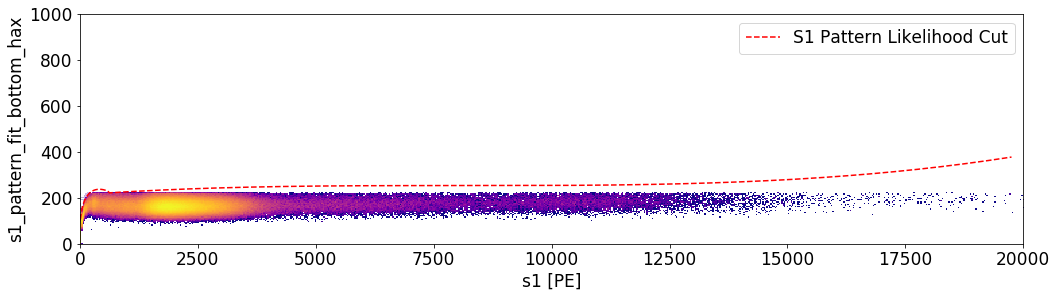

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars


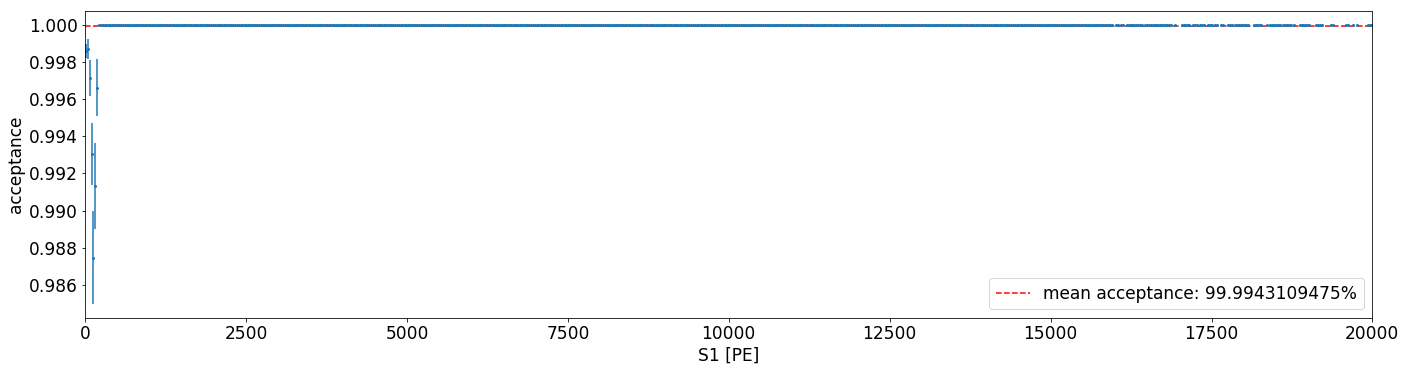

In [40]:
y_valid_top_white = []
for i in range(len(xbins_center_valid_top_white)):
    y_valid_top_white.append((S1PatternLikelihoodProfile_old_2(xbins_center_valid_top_white[i], *popt_1_top_white))*\
                             (xbins_center_valid_top_white[i]<xbins_center_valid_top_white[idx_top_white][1]) + \
                            (poly3(xbins_center_valid_top_white[i], *popt_2_top_white))*\
                             (xbins_center_valid_top_white[i]>=xbins_center_valid_top_white[idx_top_white][1]))

plt.figure(figsize=(15,8))
plt.subplot(211)
hist_top_white, xbins_top_white, ybins_top_white, _ = plt.hist2d(data_top_white['s1'], data_top_white['s1_pattern_fit_bottom_hax'], 
                                                                 bins = (700, 200), 
                                                                 range=((0,2e4), (0,1000)), 
                                                                 cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                                                 cmin = 1,alpha = 0.3)
hist_top_cut, xbins_top_cut, ybins_top_cut, _ = plt.hist2d(data_top_cut['s1'], data_top_cut['s1_pattern_fit_bottom_hax'], 
                                                           bins = (700, 200), 
                                                           range=((0,2e4), (0,1000)), 
                                                           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                                           cmin = 1,alpha = 1)
plt.plot(xbins_center_valid_top_white, y_valid_top_white, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist_top_white[np.isnan(hist_top_white)] = 0
hist_top_cut[np.isnan(hist_top_cut)] = 0

bin_centers_acceptance_top = []
acceptance_top = []
sigma_top = []
for i in range(len(xbins_top_cut)-1):
    bin_centers_acceptance_top.append((xbins_top_cut[i+1] + xbins_top_cut[i])/2.)
    acceptance_top.append(hist_top_cut[i].sum()/hist_top_white[i].sum())
    sigma_top.append(np.sqrt(acceptance_top[i]*(1-acceptance_top[i])/hist_top_white[i].sum()))
    
bin_centers_acceptance_top = np.array(bin_centers_acceptance_top)
acceptance_top = np.array(acceptance_top)
sigma_top = np.array(sigma_top)
acceptance_top_nan = acceptance_top[np.logical_not(np.isnan(acceptance_top))]
sigma_top_nan = sigma_top[np.logical_not(np.isnan(sigma_top))]
acceptance_mean_top = np.mean(acceptance_top_nan)
acceptance_median_top = np.median(acceptance_top_nan)

plt.subplot(212)

plt.errorbar(bin_centers_acceptance_top, acceptance_top, yerr=sigma_top, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean_top, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean_top) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


Unnamed selection: 41 rows removed (59.00% passed)


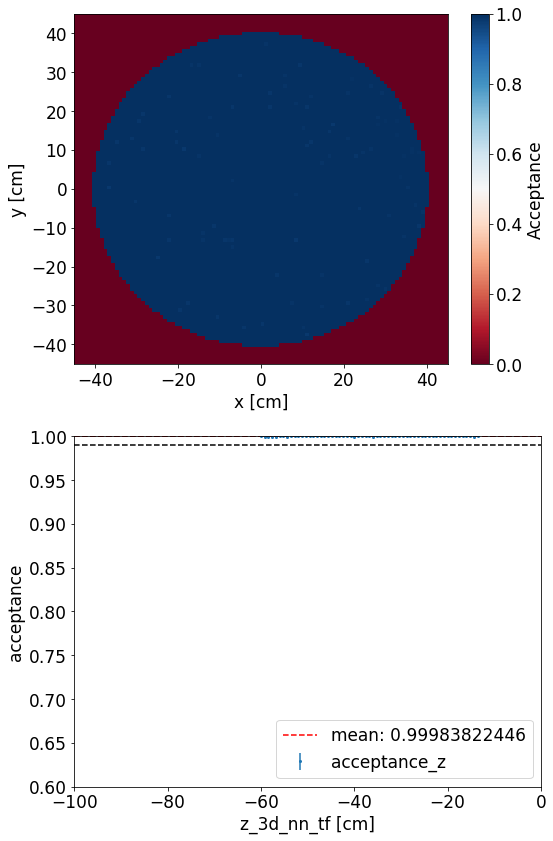

In [41]:
plt.figure(figsize=(8,12))

plt.subplot(211)
hist_data_top, x_data_top, y_data_top = np.histogram2d(data_top_white['x_3d_nn_tf'], data_top_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_top, x_cut_top, y_cut_top = np.histogram2d(data_top_cut['x_3d_nn_tf'], data_top_cut['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_top = hist_cut_top/hist_data_top
c_top = plt.pcolor(x_data_top, y_data_top, Acceptance_xy_top, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_top, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.subplot(212)
hist_top_white, xbins_top_white, ybins_top_white = np.histogram2d(data_top_white['z_3d_nn_tf'], data_top_white['s1_pattern_fit_bottom_hax'],
                                                                     bins=(100,1000), range=((-90, -10), (0.0,1000)))

hist_top_cut, xbins_top_cut, ybins_top_cut = np.histogram2d(data_top_cut['z_3d_nn_tf'], data_top_cut['s1_pattern_fit_bottom_hax'],
                                                               bins=(100,1000), range=((-90, -10), (0.0,1000)))

hist_top_white[np.isnan(hist_top_white)] = 0
hist_top_cut[np.isnan(hist_top_cut)] = 0

bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_top_cut[i].sum()/hist_top_white[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_top_white[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)

tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

del tmp

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.legend(loc='lower right')
plt.xlim(-100, 0)
plt.ylim(0.60, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')

plt.tight_layout()

# BOTTOM

In [42]:
data_bottom_white = z3_white
data_bottom = z3

In [43]:
hist_bottom_white_1, xbins_bottom_white_1, ybins_bottom_white_1 = np.histogram2d(data_bottom_white['s1'], data_bottom_white['s1_pattern_fit_bottom_hax'], 
                                                                        bins = (30, 200), 
                                                                        range=((0,600), (0,1000))
                                                                        )
ybins_center_bottom_white_1 = [0.5*(ybins_bottom_white_1[i]+ybins_bottom_white_1[i+1]) for i in range(len(ybins_bottom_white_1)-1)]
xbins_center_bottom_white_1 = [0.5*(xbins_bottom_white_1[i]+xbins_bottom_white_1[i+1]) for i in range(len(xbins_bottom_white_1)-1)]

perc_bottom_white_1 = np.empty(len(xbins_center_bottom_white_1))
for i in tqdm(range(len(hist_bottom_white_1))):
    perc_bottom_white_1[i] = percentile(index = i, hist=hist_bottom_white_1, ybins=ybins_bottom_white_1, xbins=xbins_bottom_white_1,
                                     q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_bottom_white_1, perc_valid_bottom_white_1 = dropNaNforFit(xbins_center_bottom_white_1, perc_bottom_white_1)
xbins_center_valid_bottom_white_1, perc_valid_bottom_white_1 = dropNegforFit(xbins_center_valid_bottom_white_1, perc_valid_bottom_white_1)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

hist_bottom_white_2, xbins_bottom_white_2, ybins_bottom_white_2 = np.histogram2d(data_bottom_white['s1'], data_bottom_white['s1_pattern_fit_bottom_hax'], 
                                                                        bins = (300, 200), 
                                                                        range=((600,1.5e4), (0,1000))
                                                                        )
ybins_center_bottom_white_2 = [0.5*(ybins_bottom_white_2[i]+ybins_bottom_white_2[i+1]) for i in range(len(ybins_bottom_white_2)-1)]
xbins_center_bottom_white_2 = [0.5*(xbins_bottom_white_2[i]+xbins_bottom_white_2[i+1]) for i in range(len(xbins_bottom_white_2)-1)]

perc_bottom_white_2 = np.empty(len(xbins_center_bottom_white_2))
for i in tqdm(range(len(hist_bottom_white_2))):
    perc_bottom_white_2[i] = percentile(index = i, hist=hist_bottom_white_2, ybins=ybins_bottom_white_2, xbins=xbins_bottom_white_2,
                                     q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_bottom_white_2, perc_valid_bottom_white_2 = dropNaNforFit(xbins_center_bottom_white_2, perc_bottom_white_2)
xbins_center_valid_bottom_white_2, perc_valid_bottom_white_2 = dropNegforFit(xbins_center_valid_bottom_white_2, perc_valid_bottom_white_2)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

hist_bottom_white_3, xbins_bottom_white_3, ybins_bottom_white_3 = np.histogram2d(data_bottom_white['s1'], data_bottom_white['s1_pattern_fit_bottom_hax'],
                                                                        bins = (10, 200), 
                                                                        range=((1.5e4,2e4), (0,1000))
                                                                        )
ybins_center_bottom_white_3 = [0.5*(ybins_bottom_white_3[i]+ybins_bottom_white_3[i+1]) for i in range(len(ybins_bottom_white_3)-1)]
xbins_center_bottom_white_3 = [0.5*(xbins_bottom_white_3[i]+xbins_bottom_white_3[i+1]) for i in range(len(xbins_bottom_white_3)-1)]

perc_bottom_white_3 = np.empty(len(xbins_center_bottom_white_3))
for i in tqdm(range(len(hist_bottom_white_3))):
    perc_bottom_white_3[i] = percentile(index = i, hist=hist_bottom_white_3, ybins=ybins_bottom_white_3, xbins=xbins_bottom_white_3, q=0.997, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid_bottom_white_3, perc_valid_bottom_white_3 = dropNaNforFit(xbins_center_bottom_white_3, perc_bottom_white_3)
xbins_center_valid_bottom_white_3, perc_valid_bottom_white_3 = dropNegforFit(xbins_center_valid_bottom_white_3, perc_valid_bottom_white_3)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99,7% s1 pattern fit

100%|██████████| 10/10 [00:00<00:00, 11.99it/s]


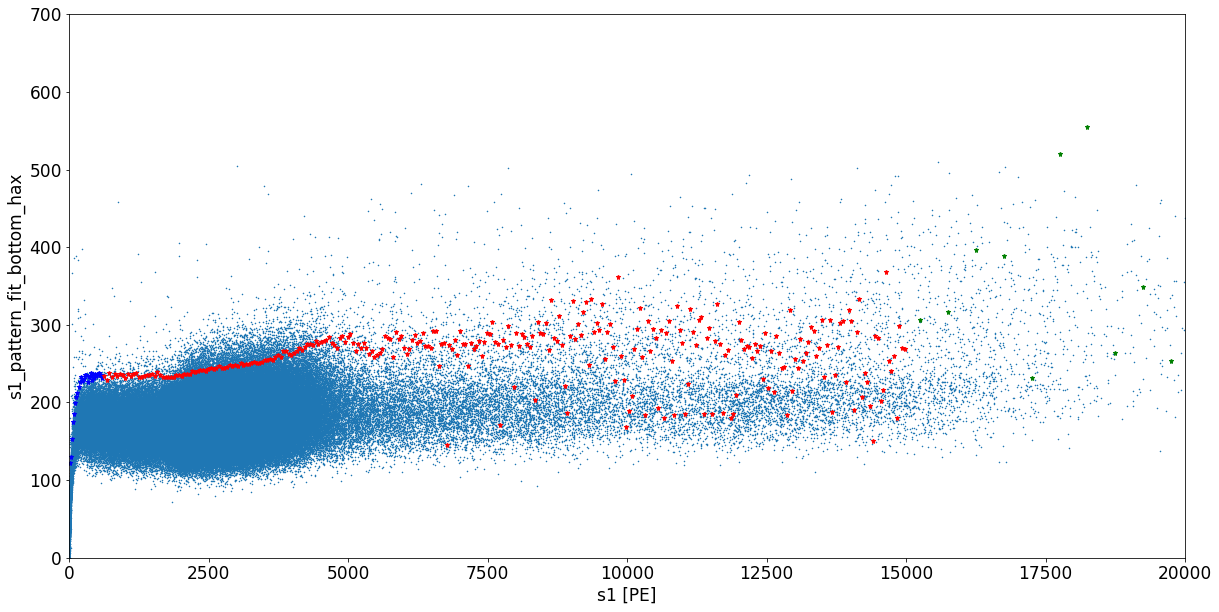

In [44]:
plt.plot(data_bottom_white['s1'], data_bottom_white['s1_pattern_fit_bottom_hax'], '*', ms=1)
plt.plot(xbins_center_valid_bottom_white_1, perc_valid_bottom_white_1, 'b*', lw=2, ms=5)
plt.plot(xbins_center_valid_bottom_white_2, perc_valid_bottom_white_2, 'r*', lw=2, ms=5)
plt.plot(xbins_center_valid_bottom_white_3, perc_valid_bottom_white_3, 'g*', lw=2, ms=5)

plt.xlim(0,2e4)
plt.ylim(0,700)

plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

[  5.45872853e+01   1.76215496e+01  -4.04532941e-01  -9.91982373e-04] 

 [[  8.94527673e+01  -2.20155583e+01   1.57703317e+00  -3.43957464e-02]
 [ -2.20155583e+01   5.93109760e+00  -4.46770153e-01   1.00618728e-02]
 [  1.57703317e+00  -4.46770153e-01   3.47916695e-02  -8.02171404e-04]
 [ -3.43957464e-02   1.00618728e-02  -8.02171404e-04   1.88253730e-05]]
[  2.22738437e+02   8.15653010e-03  -7.03429785e-07   2.26826861e-11] 

 [[  2.23945005e+01  -9.02427912e-03   9.79393445e-07  -3.11101959e-11]
 [ -9.02427912e-03   4.39311447e-06  -5.20820411e-10   1.74668692e-14]
 [  9.79393445e-07  -5.20820411e-10   6.55101676e-14  -2.29629468e-18]
 [ -3.11101959e-11   1.74668692e-14  -2.29629468e-18   8.35900039e-23]]


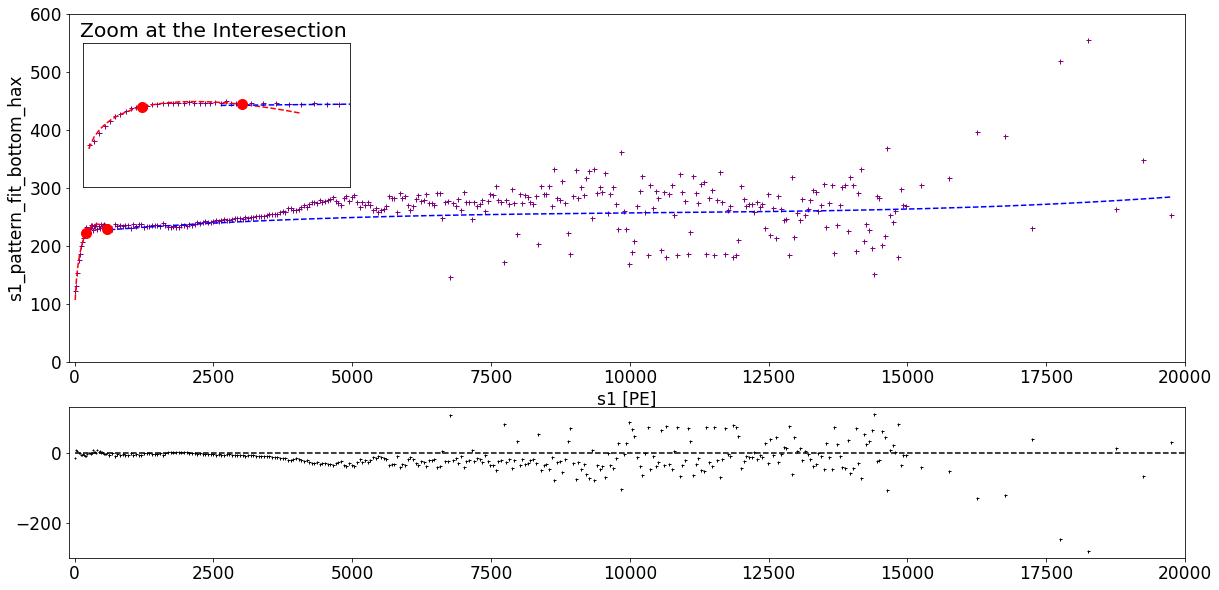

In [45]:
xbins_center_valid_bottom_white = np.concatenate((xbins_center_valid_bottom_white_1, xbins_center_valid_bottom_white_2, xbins_center_valid_bottom_white_3))
perc_valid_bottom_white = np.concatenate((perc_valid_bottom_white_1, perc_valid_bottom_white_2, perc_valid_bottom_white_3))

init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02]#, 6.10027892e-04]

popt_1_bottom_white, pcov_1_bottom_white = curve_fit(S1PatternLikelihoodProfile_old_2, xbins_center_valid_bottom_white[:30], perc_valid[:30], p0=init_1)
print(popt_1_bottom_white ,'\n\n', pcov_1_bottom_white)

init_2 = [1.94732562e+02, 2.06418467e-02, -2.51207789e-06, 9.83912470e-11]

popt_2_bottom_white, pcov_2_bottom_white = curve_fit(poly3, xbins_center_valid_bottom_white[30:], perc_valid[30:], p0=init_2)
print(popt_2_bottom_white, '\n\n', pcov_2_bottom_white)

idx_bottom_white = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white, *popt_1_bottom_white) - \
                                  poly3(xbins_center_valid_bottom_white, *popt_2_bottom_white)))).flatten()

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])

plt.plot(xbins_center_valid_bottom_white[:], perc_valid_bottom_white[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid_bottom_white[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white[:31], *popt_1_bottom_white), 'r--')
plt.plot(xbins_center_valid_bottom_white[30:], poly3(xbins_center_valid_bottom_white[30:], *popt_2_bottom_white), 'b--')
plt.plot(xbins_center_valid_bottom_white[idx_bottom_white], S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white[idx_bottom_white], *popt_1_bottom_white), 'ro' , ms=10)
plt.xlim(-100, 2e4)
plt.ylim(0,600)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.axes([0.135, 0.64, .185, .2], facecolor='w')
plt.plot(xbins_center_valid_bottom_white[:], perc_valid[:], '+', ms=5, c='purple')
plt.plot(xbins_center_valid_bottom_white[:35], S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white[:35], *popt_1_bottom_white), 'r--')
plt.plot(xbins_center_valid_bottom_white[25:], poly3(xbins_center_valid_bottom_white[25:], *popt_2_bottom_white), 'b--')
plt.plot(xbins_center_valid_bottom_white[idx_bottom_white], S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white[idx_bottom_white], *popt_1_bottom_white), 'ro' , ms=10)
plt.xlim(-10, 10e2)
plt.ylim(0,400)
plt.xticks([])
plt.yticks([])
plt.title('Zoom at the Interesection ')
#plt.xlabel('s1 [PE]')
#plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid_bottom_white[:31], S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white[:31], *popt_1_bottom_white)-perc_valid_bottom_white[:31], 
         'k+', ms=2)
plt.plot(xbins_center_valid_bottom_white[30:], poly3(xbins_center_valid_bottom_white[30:], *popt_2_bottom_white)-perc_valid_bottom_white[30:], 
         'k+', ms=3)
plt.hlines(y=0, xmin=0, xmax=2e4, linestyles='dashed')
plt.xlim(-100, 2e4)

plt.show()

In [46]:
data_bottom_cut = data_bottom_white.copy()
data_bottom_cut['CutS1PF'] = (((data_bottom_cut['s1_pattern_fit_bottom_hax'] < S1PatternLikelihoodProfile_old_2(data_bottom_cut['s1'], *popt_1_bottom_white))*\
                            (data_bottom_cut['s1']<xbins_center_valid_bottom_white[idx_bottom_white][1]))\
                           +((data_bottom_cut['s1_pattern_fit_bottom_hax'] < poly3(data_bottom_cut['s1'], *popt_2_bottom_white))*\
                             (data_bottom_cut['s1']>=xbins_center_valid_bottom_white[idx_bottom_white][1])))

data_bottom_cut = hax.cuts.selection(data_bottom_cut, data_bottom_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 8476 rows removed (97.35% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


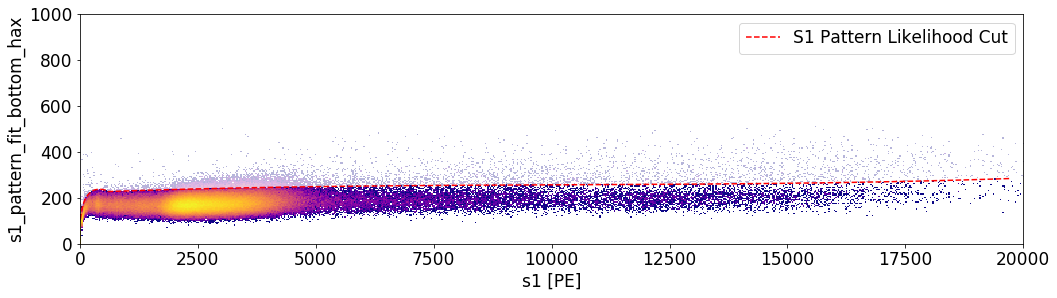

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars


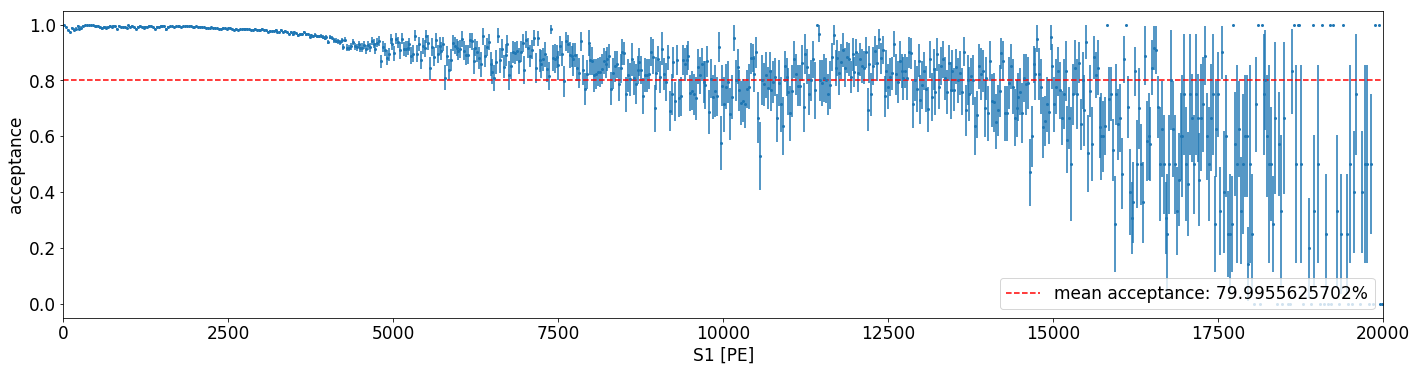

In [47]:
y_valid_bottom_white = []
for i in range(len(xbins_center_valid_bottom_white)):
    y_valid_bottom_white.append((S1PatternLikelihoodProfile_old_2(xbins_center_valid_bottom_white[i], *popt_1_bottom_white))*\
                             (xbins_center_valid_bottom_white[i]<xbins_center_valid_bottom_white[idx_bottom_white][1]) + \
                            (poly3(xbins_center_valid_bottom_white[i], *popt_2_bottom_white))*\
                             (xbins_center_valid_bottom_white[i]>=xbins_center_valid_bottom_white[idx_bottom_white][1]))

plt.figure(figsize=(15,8))
plt.subplot(211)
hist_bottom_white, xbins_bottom_white, ybins_bottom_white, _ = plt.hist2d(data_bottom_white['s1'], data_bottom_white['s1_pattern_fit_bottom_hax'], 
                                                                 bins = (700, 200), 
                                                                 range=((0,2e4), (0,1000)), 
                                                                 cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                                                 cmin = 1,alpha = 0.3)
hist_bottom_cut, xbins_bottom_cut, ybins_bottom_cut, _ = plt.hist2d(data_bottom_cut['s1'], data_bottom_cut['s1_pattern_fit_bottom_hax'], 
                                                           bins = (700, 200), 
                                                           range=((0,2e4), (0,1000)), 
                                                           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
                                                           cmin = 1,alpha = 1)
plt.plot(xbins_center_valid_bottom_white, y_valid_bottom_white, 'r--', label = 'S1 Pattern Likelihood Cut')
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()
hist_bottom_white[np.isnan(hist_bottom_white)] = 0
hist_bottom_cut[np.isnan(hist_bottom_cut)] = 0

bin_centers_acceptance_bottom = []
acceptance_bottom = []
sigma_bottom = []
for i in range(len(xbins_bottom_cut)-1):
    bin_centers_acceptance_bottom.append((xbins_bottom_cut[i+1] + xbins_bottom_cut[i])/2.)
    acceptance_bottom.append(hist_bottom_cut[i].sum()/hist_bottom_white[i].sum())
    sigma_bottom.append(np.sqrt(acceptance_bottom[i]*(1-acceptance_bottom[i])/hist_bottom_white[i].sum()))
    
bin_centers_acceptance_bottom = np.array(bin_centers_acceptance_bottom)
acceptance_bottom = np.array(acceptance_bottom)
sigma_bottom = np.array(sigma_bottom)
acceptance_bottom_nan = acceptance_bottom[np.logical_not(np.isnan(acceptance_bottom))]
sigma_bottom_nan = sigma_bottom[np.logical_not(np.isnan(sigma_bottom))]
acceptance_mean_bottom = np.mean(acceptance_bottom_nan)
acceptance_median_bottom = np.median(acceptance_bottom_nan)

plt.subplot(212)

plt.errorbar(bin_centers_acceptance_bottom, acceptance_bottom, yerr=sigma_bottom, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean_bottom, xmin=0, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean_bottom) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

plt.tight_layout()
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


Unnamed selection: 70 rows removed (30.00% passed)


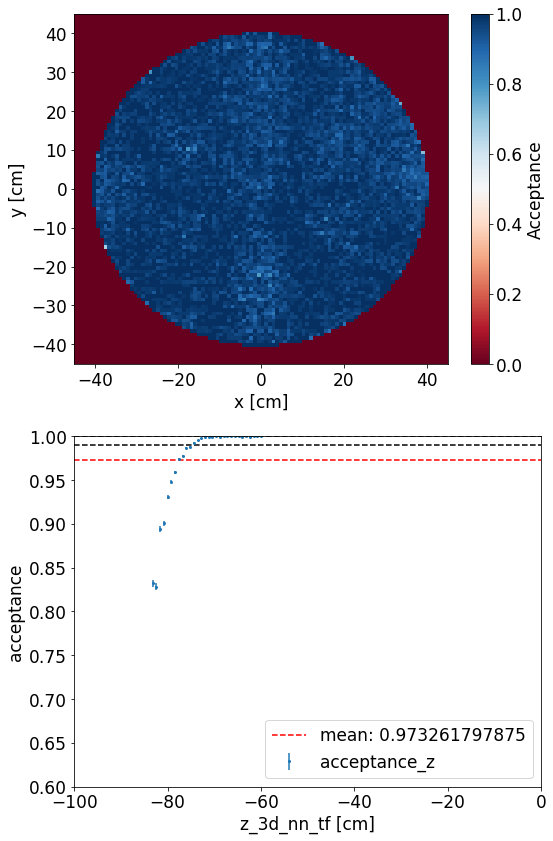

In [48]:
plt.figure(figsize=(8,12))

plt.subplot(211)
hist_data_top, x_data_top, y_data_top = np.histogram2d(data_bottom_white['x_3d_nn_tf'], data_bottom_white['y_3d_nn_tf'], 
                                                 bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut_top, x_cut_top, y_cut_top = np.histogram2d(data_bottom_cut['x_3d_nn_tf'], data_bottom_cut['y_3d_nn_tf'], 
                                              bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy_top = hist_cut_top/hist_data_top
c_top = plt.pcolor(x_data_top, y_data_top, Acceptance_xy_top, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c_top, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.subplot(212)
hist_bottom_white, xbins_bottom_white, ybins_bottom_white = np.histogram2d(data_bottom_white['z_3d_nn_tf'], data_bottom_white['s1_pattern_fit_bottom_hax'],
                                                                     bins=(100,1000), range=((-90, -10), (0.0,1000)))

hist_bottom_cut, xbins_bottom_cut, ybins_bottom_cut = np.histogram2d(data_bottom_cut['z_3d_nn_tf'], data_bottom_cut['s1_pattern_fit_bottom_hax'],
                                                               bins=(100,1000), range=((-90, -10), (0.0,1000)))

hist_bottom_white[np.isnan(hist_bottom_white)] = 0
hist_bottom_cut[np.isnan(hist_bottom_cut)] = 0

bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_bottom_cut[i].sum()/hist_bottom_white[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_bottom_white[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)

tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

del tmp

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.legend(loc='lower right')
plt.xlim(-100, 0)
plt.ylim(0.60, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')

plt.tight_layout()